In [41]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

In [75]:
sunMass = 1.989e30 # kg
solarRadius = 695.51e6 # meters

# Function evaluates the orbital separation at time t, starting from separation r0.
def separationTimeTScalar(m1, m2, r0, t, G=6.674e-8, c=3e8):
    r = (4 * -(64.0/5.0) * (G**3/c**5) * (m1*m2)*(m1+m2) * t  +  r0**4.0)**(1.0/4.0)
    if np.isnan(r):
        return 0
    return r

# Function compares separation r with evolved separation r0 after some time t. Returns 1 if within tolerance of similarity.
def forwardedOrbitDelta(r, m1, m2, r0, t, G=6.674e-8, c=3e8, tolFrac=0.005):
    rNew = separationTimeTScalar(m1, m2, r0, t, G=6.674e-8, c=3e8)
    if abs(r-rNew)<tolFrac*rNew: # Return 1 if the forwarded in time r0 equals r.
        return 1
    else:
        return 0



# NOT USED FOR CALCULATIONS
def orbitDecay_drdt(m1, m2, r, G=6.674e-8, c=3e8):
    return -(64.0/5.0) * (G**3/c**5) * (m1*m2)*(m1+m2) / r**3

# Function evaluates the orbital separation at time t, starting from separation r0. If delta=True, returns 0 if collided.
# NOT USED FOR CALCULATIONS
def orbR(m1, m2, r0, t, G=6.674e-8, c=3e8, delta=True):
    r = (4 * -(64.0/5.0) * (G**3/c**5) * (m1*m2)*(m1+m2) * t  +  r0**4.0)**(1.0/4.0)
    
    if np.isnan(r).any():
        nanLocations = np.isnan(r) # Remove NaN values from numerical errors
        if np.ndim(r) != 0: # If r is an array
            r[nanLocations] = 0
        else:
            r = 0 # If r is a scalar
    if delta:
        return np.less(np.zeros(r.shape), r).astype(int) # delta function =0 for r <=0
    return r


In [82]:
print("Tests:")
print(forwardedOrbitDelta(10e7, sunMass, sunMass, 10e7, t=1))
print(forwardedOrbitDelta(10e7, sunMass, sunMass, 10e7, t=25))

print("One second later the distances are deemed close enought to be the same, 25s later and they are not.")

Tests:
1
0
One second later the distances are deemed close enought to be the same, 25s later and they are not.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in power


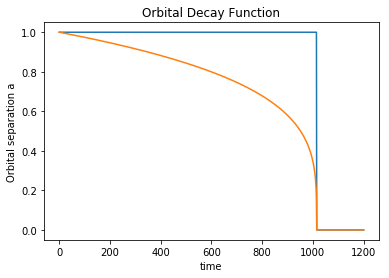

In [50]:
dom = np.linspace(0,1200,1000)
r = orbR(sunMass, sunMass, 10e7, dom, G=6.674e-8, c=3e8, delta=True)
r2 = orbR(sunMass, sunMass, 10e7, dom, G=6.674e-8, c=3e8, delta=False)
plt.plot(dom, r)
plt.plot(dom, r2 / 10e7)
plt.title("Orbital Decay Function")
plt.xlabel('time')
plt.ylabel('Orbital separation a')
plt.show()

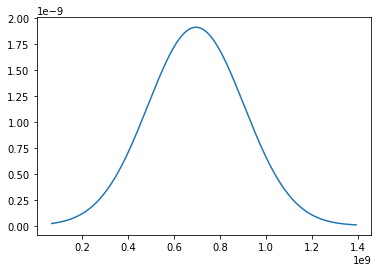

In [5]:
# We want to integrate over the birth-parameter space theta_b.
# We investigate simplest case of one parameter, the birth separation which is distributed as a gaussian which we integrate over:
# https://arxiv.org/pdf/1806.05820.pdf Figure 1 for ballpark radii and masses for birth BNS
pi_ab = lambda a_b: scipy.stats.norm(1*solarRadius, 0.3*solarRadius).pdf(a_b)

plt.plot(np.linspace(0.1*solarRadius, 2*solarRadius, 1000), pi_ab(np.linspace(0.1*solarRadius, 2*solarRadius, 1000)))
plt.show()

We wish to investigate the probabilities of separation a_x at time t, given a birth parameter population $a_b\in\theta_b$. To do so:  

$\pi_t(\theta_x|\Lambda_b)=\int dt \int d\theta_b \pi(t) \pi(\theta_x|\theta_b,t) \pi(\theta_b|\Lambda_b)$

OR in 1D:

$\pi_t(a_x|\Lambda_b)=\int dt \int da_b \pi(t) \pi(a_x|a_b,t) \pi(a_b|\Lambda_b)$

We loop over a range of present separations a_x; then the above integral is calculated by discretising the a_b integral. This is done by sampling (at even intervals) the above hierarchical model which describes the birth parameters, then the integrand is computed using $\pi(a_x|a_b,t)$ to act like a delta function which "combs" for whether $a_b\rightarrow a_x$ after some time t (return 1 if evolved a_b=a_x). 

Currently the code is too slow to cover the domain a_x at fine precision do to the inner loop over all the birth separations. I am thinking is damaging as the $\pi(a_x|a_b,t)$ delta function misses orbits which actually have probablity? perhaps explaining the a_xPr results all being the same ~1% due to accumulated errors?

I think this should be faster by properly numerically integrating both integrals, however I am not sure how to do this in the same step as the time evolution of the birth parameters, as these birth parameters are also integrated over. Perhaps consider alternating order of integration

Currently exploring increasing separation distance similarity tolerance, changing density of a_b population and of a_x spacing.


In [6]:
%xmode

Exception reporting mode: Verbose


In [86]:
#### 
TOLERANCE = 0.05 # a_x and evolved a_b will be considered the same if abs(r1-r2)<tolFrac*r1

# We want to integrate from time t_i to t_f
t_i, t_f = 0.0, 30.0 # Time integrated over

#### Flat time distribution
pi_t = lambda t: scipy.stats.uniform(t_i, t_f-t_i).pdf(t)
####

######### pi_thetaX_given_thetaB_t should be like a delta function at time t.
#pi_thetaX_given_thetaB_t = lambda a_x, a_b, t: orbR(sunMass, sunMass, a_b, t, G=6.674e-8, c=3e8, delta=True)
pi_thetaX_given_thetaB_t = lambda a_x, a_b, t: forwardedOrbitDelta(a_x, sunMass, sunMass, a_b, t, G=6.674e-8, c=3e8, tolFrac=TOLERANCE)
#########

######## Probability of model parameters
pi_thetaB_given_LambdaB = lambda a_b: pi_ab(a_b)
########

#########
integrand = lambda a_x, a_b, t: pi_t(t) * pi_thetaX_given_thetaB_t(a_x, a_b, t) * pi_thetaB_given_LambdaB(a_b)
#########

# To integrate over a discretised birth population we first need to create birth pop:
# ONLY 10 BIRTH SEPARATIONS
# a_bDomain = np.linspace(0.1*solarRadius, 2*solarRadius, 10)
# a_bPop = pi_ab(a_bDomain)
# a_bDelta = a_bDomain[1] - a_bDomain[0] # Spacing

a_bPop = np.random.normal(solarRadius, 0.1*solarRadius, 100)

# We want to perform this integral over a range of potentially observable systems with some parameter set theta_x at time t.
# In this 1D case we look at just a range of 20 values of a_x from 0 to 100*solarRadius.
# Not anymore, we look in some area around solar radius:
a_xDomain = np.linspace(solarRadius-0.2*solarRadius, solarRadius+0.2*solarRadius, 50)
a_xPr = []
for i, a_x in enumerate(a_xDomain):
    print("Calculating probability of a_x={}...".format(a_x))
    print("%{} completed.".format(100*float(i)/len(a_xDomain)))
    
    # First integrating over a_b domain (birth parameters)
    a_bIntegralTotal = 0
    for a_b in a_bPop:
        print("a_x, a_b == ", a_x, a_b)
        integrandArgumented = lambda t: integrand(a_x, a_b, t) # So we can use it as a function of t below:
        
        try: # Sometimes there is an error...
            # Take [0] as this is the integral result, [1] is the error.
            integralResult = scipy.integrate.quad(integrandArgumented, t_i, t_f)[0] #* a_bDelta
            a_bIntegralTotal += integralResult
            
            if integralResult > 0:
                print("!!!!!!!!!!!Found contribution!!!!!!!!!!!! {}".format(integralResult))
        except Exception as e:
            print(e)

        
    # Join probability onto end of list
    a_xPr.append(a_bIntegralTotal)

Calculating probability of a_x=556408000.0...
a_x, a_b ==  556408000.0 759059470.359
a_x, a_b ==  556408000.0 626239340.611
a_x, a_b ==  556408000.0 713001427.79
a_x, a_b ==  556408000.0 651521560.231
a_x, a_b ==  556408000.0 677467062.694
a_x, a_b ==  556408000.0 761438018.54
a_x, a_b ==  556408000.0 562568604.05
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.5607551713504576e-09
a_x, a_b ==  556408000.0 811478348.505
a_x, a_b ==  556408000.0 679837325.131
a_x, a_b ==  556408000.0 821583436.148
a_x, a_b ==  556408000.0 590657494.936
a_x, a_b ==  556408000.0 652837974.658
a_x, a_b ==  556408000.0 702329278.878
a_x, a_b ==  556408000.0 664507908.787
a_x, a_b ==  556408000.0 681649524.254
a_x, a_b ==  556408000.0 724843242.837
a_x, a_b ==  556408000.0 656997411.93
a_x, a_b ==  556408000.0 655125585.844
a_x, a_b ==  556408000.0 635434838.476
a_x, a_b ==  556408000.0 714233383.16
a_x, a_b ==  556408000.0 696215728.135
a_x, a_b ==  556408000.0 776001907.81
a_x, a_b ==  556408000.0 551833327.04

a_x, a_b ==  567763265.306 654657959.416
a_x, a_b ==  567763265.306 551838563.784
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.508449566647331e-09
a_x, a_b ==  567763265.306 658472444.92
a_x, a_b ==  567763265.306 854779978.863
a_x, a_b ==  567763265.306 773471000.186
a_x, a_b ==  567763265.306 706700793.216
a_x, a_b ==  567763265.306 685983533.179
a_x, a_b ==  567763265.306 842821676.62
a_x, a_b ==  567763265.306 643382692.143
a_x, a_b ==  567763265.306 759322354.714
a_x, a_b ==  567763265.306 693385225.451
a_x, a_b ==  567763265.306 770513957.005
a_x, a_b ==  567763265.306 737244699.522
a_x, a_b ==  567763265.306 658031102.159
a_x, a_b ==  567763265.306 689217475.139
a_x, a_b ==  567763265.306 593571704.285
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.6968974705651229e-09
a_x, a_b ==  567763265.306 663419657.212
a_x, a_b ==  567763265.306 815113491.282
a_x, a_b ==  567763265.306 758265531.515
Calculating probability of a_x=573440897.9591837...
a_x, a_b ==  573440897.959 759059470.359
a

a_x, a_b ==  579118530.612 697782851.132
a_x, a_b ==  579118530.612 837029369.221
a_x, a_b ==  579118530.612 668643443.263
a_x, a_b ==  579118530.612 778942201.968
a_x, a_b ==  579118530.612 757503954.316
a_x, a_b ==  579118530.612 583936755.923
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.6572763413588995e-09
a_x, a_b ==  579118530.612 726353317.802
a_x, a_b ==  579118530.612 634244716.573
a_x, a_b ==  579118530.612 567024394.095
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.5817754731553445e-09
a_x, a_b ==  579118530.612 739149310.605
a_x, a_b ==  579118530.612 747866679.884
a_x, a_b ==  579118530.612 697829606.306
a_x, a_b ==  579118530.612 676780481.633
a_x, a_b ==  579118530.612 628778238.525
a_x, a_b ==  579118530.612 728697846.235
a_x, a_b ==  579118530.612 713252140.017
a_x, a_b ==  579118530.612 763207880.791
a_x, a_b ==  579118530.612 654657959.416
a_x, a_b ==  579118530.612 551838563.784
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.508449566647331e-09
a_x, a_b ==  579118530.612 

a_x, a_b ==  596151428.571 641712215.631
a_x, a_b ==  596151428.571 713295445.403
a_x, a_b ==  596151428.571 740546891.467
a_x, a_b ==  596151428.571 623329652.921
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8009399009188134e-09
a_x, a_b ==  596151428.571 704990740.392
a_x, a_b ==  596151428.571 686202209.826
a_x, a_b ==  596151428.571 721455850.941
a_x, a_b ==  596151428.571 746348799.07
a_x, a_b ==  596151428.571 635353654.305
a_x, a_b ==  596151428.571 704486895.912
a_x, a_b ==  596151428.571 676891020.079
a_x, a_b ==  596151428.571 735997774.082
a_x, a_b ==  596151428.571 697782851.132
a_x, a_b ==  596151428.571 837029369.221
a_x, a_b ==  596151428.571 668643443.263
a_x, a_b ==  596151428.571 778942201.968
a_x, a_b ==  596151428.571 757503954.316
a_x, a_b ==  596151428.571 583936755.923
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.6572763413588995e-09
a_x, a_b ==  596151428.571 726353317.802
a_x, a_b ==  596151428.571 634244716.573
a_x, a_b ==  596151428.571 567024394.095
a_x, a_b =

a_x, a_b ==  618861959.184 731506828.977
a_x, a_b ==  618861959.184 675534316.969
a_x, a_b ==  618861959.184 745828458.327
a_x, a_b ==  618861959.184 689713508.372
a_x, a_b ==  618861959.184 732757670.848
a_x, a_b ==  618861959.184 785387955.622
a_x, a_b ==  618861959.184 644736333.748
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.856210288885246e-09
a_x, a_b ==  618861959.184 774743091.187
a_x, a_b ==  618861959.184 772652410.393
a_x, a_b ==  618861959.184 643594297.194
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8537118946617823e-09
a_x, a_b ==  618861959.184 771804072.031
a_x, a_b ==  618861959.184 580317232.768
a_x, a_b ==  618861959.184 573330411.68
a_x, a_b ==  618861959.184 672452219.231
a_x, a_b ==  618861959.184 653494288.889
a_x, a_b ==  618861959.184 671736243.559
a_x, a_b ==  618861959.184 567720079.359
a_x, a_b ==  618861959.184 688519776.021
a_x, a_b ==  618861959.184 657933894.112
a_x, a_b ==  618861959.184 679349278.199
a_x, a_b ==  618861959.184 594455659.589
!!!!!!!!!!!

a_x, a_b ==  635894857.143 700161734.378
a_x, a_b ==  635894857.143 613764712.375
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7707440932648106e-09
a_x, a_b ==  635894857.143 587164773.987
a_x, a_b ==  635894857.143 641712215.631
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8494809658026803e-09
a_x, a_b ==  635894857.143 713295445.403
a_x, a_b ==  635894857.143 740546891.467
a_x, a_b ==  635894857.143 623329652.921
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8009399009188134e-09
a_x, a_b ==  635894857.143 704990740.392
a_x, a_b ==  635894857.143 686202209.826
a_x, a_b ==  635894857.143 721455850.941
a_x, a_b ==  635894857.143 746348799.07
a_x, a_b ==  635894857.143 635353654.305
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8341540854601428e-09
a_x, a_b ==  635894857.143 704486895.912
a_x, a_b ==  635894857.143 676891020.079
a_x, a_b ==  635894857.143 735997774.082
a_x, a_b ==  635894857.143 697782851.132
a_x, a_b ==  635894857.143 837029369.221
a_x, a_b ==  635894857.143 668643443.263
!!!

a_x, a_b ==  647250122.449 643382692.143
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8532432464001159e-09
a_x, a_b ==  647250122.449 759322354.714
a_x, a_b ==  647250122.449 693385225.451
a_x, a_b ==  647250122.449 770513957.005
a_x, a_b ==  647250122.449 737244699.522
a_x, a_b ==  647250122.449 658031102.159
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.881392007531375e-09
a_x, a_b ==  647250122.449 689217475.139
a_x, a_b ==  647250122.449 593571704.285
a_x, a_b ==  647250122.449 663419657.212
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8895095553170664e-09
a_x, a_b ==  647250122.449 815113491.282
a_x, a_b ==  647250122.449 758265531.515
Calculating probability of a_x=652927755.1020408...
a_x, a_b ==  652927755.102 759059470.359
a_x, a_b ==  652927755.102 626239340.611
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.809472851026671e-09
a_x, a_b ==  652927755.102 713001427.79
a_x, a_b ==  652927755.102 651521560.231
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8699681674404317e-09
a_x, a_b ==

!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8812343685185493e-09
a_x, a_b ==  658605387.755 679349278.199
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.906262857791002e-09
a_x, a_b ==  658605387.755 594455659.589
a_x, a_b ==  658605387.755 696257386.402
a_x, a_b ==  658605387.755 785690145.675
a_x, a_b ==  658605387.755 626247590.722
a_x, a_b ==  658605387.755 700161734.378
a_x, a_b ==  658605387.755 613764712.375
a_x, a_b ==  658605387.755 587164773.987
a_x, a_b ==  658605387.755 641712215.631
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8494809658026803e-09
a_x, a_b ==  658605387.755 713295445.403
a_x, a_b ==  658605387.755 740546891.467
a_x, a_b ==  658605387.755 623329652.921
a_x, a_b ==  658605387.755 704990740.392
a_x, a_b ==  658605387.755 686202209.826
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.910087746762974e-09
a_x, a_b ==  658605387.755 721455850.941
a_x, a_b ==  658605387.755 746348799.07
a_x, a_b ==  658605387.755 635353654.305
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.83

a_x, a_b ==  669960653.061 652837974.658
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.872419787326097e-09
a_x, a_b ==  669960653.061 702329278.878
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.910968327553363e-09
a_x, a_b ==  669960653.061 664507908.787
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.891000109125348e-09
a_x, a_b ==  669960653.061 681649524.254
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.907775297458979e-09
a_x, a_b ==  669960653.061 724843242.837
a_x, a_b ==  669960653.061 656997411.93
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8796954855286574e-09
a_x, a_b ==  669960653.061 655125585.844
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.876510070783101e-09
a_x, a_b ==  669960653.061 635434838.476
a_x, a_b ==  669960653.061 714233383.16
a_x, a_b ==  669960653.061 696215728.135
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.91197825317808e-09
a_x, a_b ==  669960653.061 776001907.81
a_x, a_b ==  669960653.061 551833327.04
a_x, a_b ==  669960653.061 782978625.507
a_x, a_b ==  669960653.

a_x, a_b ==  681315918.367 728697846.235
a_x, a_b ==  681315918.367 713252140.017
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.905089439324136e-09
a_x, a_b ==  681315918.367 763207880.791
a_x, a_b ==  681315918.367 654657959.416
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.875691555276636e-09
a_x, a_b ==  681315918.367 551838563.784
a_x, a_b ==  681315918.367 658472444.92
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8821027466719683e-09
a_x, a_b ==  681315918.367 854779978.863
a_x, a_b ==  681315918.367 773471000.186
a_x, a_b ==  681315918.367 706700793.216
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9092411966545444e-09
a_x, a_b ==  681315918.367 685983533.179
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.909997399566001e-09
a_x, a_b ==  681315918.367 842821676.62
a_x, a_b ==  681315918.367 643382692.143
a_x, a_b ==  681315918.367 759322354.714
a_x, a_b ==  681315918.367 693385225.451
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.911890056172457e-09
a_x, a_b ==  681315918.367 770513957.005
a

a_x, a_b ==  692671183.673 785387955.622
a_x, a_b ==  692671183.673 644736333.748
a_x, a_b ==  692671183.673 774743091.187
a_x, a_b ==  692671183.673 772652410.393
a_x, a_b ==  692671183.673 643594297.194
a_x, a_b ==  692671183.673 771804072.031
a_x, a_b ==  692671183.673 580317232.768
a_x, a_b ==  692671183.673 573330411.68
a_x, a_b ==  692671183.673 672452219.231
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9003501819424516e-09
a_x, a_b ==  692671183.673 653494288.889
a_x, a_b ==  692671183.673 671736243.559
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8996185251036396e-09
a_x, a_b ==  692671183.673 567720079.359
a_x, a_b ==  692671183.673 688519776.021
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9109165188118316e-09
a_x, a_b ==  692671183.673 657933894.112
a_x, a_b ==  692671183.673 679349278.199
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.906262857791002e-09
a_x, a_b ==  692671183.673 594455659.589
a_x, a_b ==  692671183.673 696257386.402
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9

a_x, a_b ==  704026448.98 745828458.327
a_x, a_b ==  704026448.98 689713508.372
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9112515355370564e-09
a_x, a_b ==  704026448.98 732757670.848
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.881765392385227e-09
a_x, a_b ==  704026448.98 785387955.622
a_x, a_b ==  704026448.98 644736333.748
a_x, a_b ==  704026448.98 774743091.187
a_x, a_b ==  704026448.98 772652410.393
a_x, a_b ==  704026448.98 643594297.194
a_x, a_b ==  704026448.98 771804072.031
a_x, a_b ==  704026448.98 580317232.768
a_x, a_b ==  704026448.98 573330411.68
a_x, a_b ==  704026448.98 672452219.231
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9003501819424516e-09
a_x, a_b ==  704026448.98 653494288.889
a_x, a_b ==  704026448.98 671736243.559
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8996185251036396e-09
a_x, a_b ==  704026448.98 567720079.359
a_x, a_b ==  704026448.98 688519776.021
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9109165188118316e-09
a_x, a_b ==  704026448.98 657933894.1

a_x, a_b ==  715381714.286 726353317.802
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.891213375320867e-09
a_x, a_b ==  715381714.286 634244716.573
a_x, a_b ==  715381714.286 567024394.095
a_x, a_b ==  715381714.286 739149310.605
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8706253091621957e-09
a_x, a_b ==  715381714.286 747866679.884
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8527332306478373e-09
a_x, a_b ==  715381714.286 697829606.306
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.9118710430910015e-09
a_x, a_b ==  715381714.286 676780481.633
a_x, a_b ==  715381714.286 628778238.525
a_x, a_b ==  715381714.286 728697846.235
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8879555046859343e-09
a_x, a_b ==  715381714.286 713252140.017
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.905089439324136e-09
a_x, a_b ==  715381714.286 763207880.791
a_x, a_b ==  715381714.286 654657959.416
a_x, a_b ==  715381714.286 551838563.784
a_x, a_b ==  715381714.286 658472444.92
a_x, a_b ==  715381714.286 854779978.86

a_x, a_b ==  726736979.592 659225690.697
a_x, a_b ==  726736979.592 731506828.977
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8837464273693136e-09
a_x, a_b ==  726736979.592 675534316.969
a_x, a_b ==  726736979.592 745828458.327
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8571915618183032e-09
a_x, a_b ==  726736979.592 689713508.372
a_x, a_b ==  726736979.592 732757670.848
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.881765392385227e-09
a_x, a_b ==  726736979.592 785387955.622
a_x, a_b ==  726736979.592 644736333.748
a_x, a_b ==  726736979.592 774743091.187
a_x, a_b ==  726736979.592 772652410.393
a_x, a_b ==  726736979.592 643594297.194
a_x, a_b ==  726736979.592 771804072.031
a_x, a_b ==  726736979.592 580317232.768
a_x, a_b ==  726736979.592 573330411.68
a_x, a_b ==  726736979.592 672452219.231
a_x, a_b ==  726736979.592 653494288.889
a_x, a_b ==  726736979.592 671736243.559
a_x, a_b ==  726736979.592 567720079.359
a_x, a_b ==  726736979.592 688519776.021
a_x, a_b ==  726736979.592 6

a_x, a_b ==  732414612.245 685983533.179
a_x, a_b ==  732414612.245 842821676.62
a_x, a_b ==  732414612.245 643382692.143
a_x, a_b ==  732414612.245 759322354.714
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.82463169357248e-09
a_x, a_b ==  732414612.245 693385225.451
a_x, a_b ==  732414612.245 770513957.005
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.792364584858236e-09
a_x, a_b ==  732414612.245 737244699.522
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8741219023741766e-09
a_x, a_b ==  732414612.245 658031102.159
a_x, a_b ==  732414612.245 689217475.139
a_x, a_b ==  732414612.245 593571704.285
a_x, a_b ==  732414612.245 663419657.212
a_x, a_b ==  732414612.245 815113491.282
a_x, a_b ==  732414612.245 758265531.515
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8274368393835493e-09
Calculating probability of a_x=738092244.8979592...
a_x, a_b ==  738092244.898 759059470.359
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.825333445262529e-09
a_x, a_b ==  738092244.898 626239340.611
a_x, a_b ==  

a_x, a_b ==  749447510.204 567024394.095
a_x, a_b ==  749447510.204 739149310.605
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8706253091621957e-09
a_x, a_b ==  749447510.204 747866679.884
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8527332306478373e-09
a_x, a_b ==  749447510.204 697829606.306
a_x, a_b ==  749447510.204 676780481.633
a_x, a_b ==  749447510.204 628778238.525
a_x, a_b ==  749447510.204 728697846.235
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8879555046859343e-09
a_x, a_b ==  749447510.204 713252140.017
a_x, a_b ==  749447510.204 763207880.791
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8139551267850098e-09
a_x, a_b ==  749447510.204 654657959.416
a_x, a_b ==  749447510.204 551838563.784
a_x, a_b ==  749447510.204 658472444.92
a_x, a_b ==  749447510.204 854779978.863
a_x, a_b ==  749447510.204 773471000.186
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7830777193613946e-09
a_x, a_b ==  749447510.204 706700793.216
a_x, a_b ==  749447510.204 685983533.179
a_x, a_b ==  7494475

a_x, a_b ==  760802775.51 745828458.327
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8571915618183032e-09
a_x, a_b ==  760802775.51 689713508.372
a_x, a_b ==  760802775.51 732757670.848
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.881765392385227e-09
a_x, a_b ==  760802775.51 785387955.622
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7425855945686898e-09
a_x, a_b ==  760802775.51 644736333.748
a_x, a_b ==  760802775.51 774743091.187
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7789874979691478e-09
a_x, a_b ==  760802775.51 772652410.393
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7856796478728024e-09
a_x, a_b ==  760802775.51 643594297.194
a_x, a_b ==  760802775.51 771804072.031
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7883510956263876e-09
a_x, a_b ==  760802775.51 580317232.768
a_x, a_b ==  760802775.51 573330411.68
a_x, a_b ==  760802775.51 672452219.231
a_x, a_b ==  760802775.51 653494288.889
a_x, a_b ==  760802775.51 671736243.559
a_x, a_b ==  760802775.51 567720079.359
a_x, a_b == 

!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8741219023741766e-09
a_x, a_b ==  766480408.163 658031102.159
a_x, a_b ==  766480408.163 689217475.139
a_x, a_b ==  766480408.163 593571704.285
a_x, a_b ==  766480408.163 663419657.212
a_x, a_b ==  766480408.163 815113491.282
a_x, a_b ==  766480408.163 758265531.515
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8274368393835493e-09
Calculating probability of a_x=772158040.8163265...
a_x, a_b ==  772158040.816 759059470.359
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.825333445262529e-09
a_x, a_b ==  772158040.816 626239340.611
a_x, a_b ==  772158040.816 713001427.79
a_x, a_b ==  772158040.816 651521560.231
a_x, a_b ==  772158040.816 677467062.694
a_x, a_b ==  772158040.816 761438018.54
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8188887652168689e-09
a_x, a_b ==  772158040.816 562568604.05
a_x, a_b ==  772158040.816 811478348.505
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.6383505521889726e-09
a_x, a_b ==  772158040.816 679837325.131
a_x, a_b == 

a_x, a_b ==  783513306.122 773471000.186
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7830777193613946e-09
a_x, a_b ==  783513306.122 706700793.216
a_x, a_b ==  783513306.122 685983533.179
a_x, a_b ==  783513306.122 842821676.62
a_x, a_b ==  783513306.122 643382692.143
a_x, a_b ==  783513306.122 759322354.714
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.82463169357248e-09
a_x, a_b ==  783513306.122 693385225.451
a_x, a_b ==  783513306.122 770513957.005
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.792364584858236e-09
a_x, a_b ==  783513306.122 737244699.522
a_x, a_b ==  783513306.122 658031102.159
a_x, a_b ==  783513306.122 689217475.139
a_x, a_b ==  783513306.122 593571704.285
a_x, a_b ==  783513306.122 663419657.212
a_x, a_b ==  783513306.122 815113491.282
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.6223166744836034e-09
a_x, a_b ==  783513306.122 758265531.515
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.8274368393835493e-09
Calculating probability of a_x=789190938.7755102...
a_x, a_b == 

a_x, a_b ==  794868571.429 688519776.021
a_x, a_b ==  794868571.429 657933894.112
a_x, a_b ==  794868571.429 679349278.199
a_x, a_b ==  794868571.429 594455659.589
a_x, a_b ==  794868571.429 696257386.402
a_x, a_b ==  794868571.429 785690145.675
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7414969853738022e-09
a_x, a_b ==  794868571.429 626247590.722
a_x, a_b ==  794868571.429 700161734.378
a_x, a_b ==  794868571.429 613764712.375
a_x, a_b ==  794868571.429 587164773.987
a_x, a_b ==  794868571.429 641712215.631
a_x, a_b ==  794868571.429 713295445.403
a_x, a_b ==  794868571.429 740546891.467
a_x, a_b ==  794868571.429 623329652.921
a_x, a_b ==  794868571.429 704990740.392
a_x, a_b ==  794868571.429 686202209.826
a_x, a_b ==  794868571.429 721455850.941
a_x, a_b ==  794868571.429 746348799.07
a_x, a_b ==  794868571.429 635353654.305
a_x, a_b ==  794868571.429 704486895.912
a_x, a_b ==  794868571.429 676891020.079
a_x, a_b ==  794868571.429 735997774.082
a_x, a_b ==  794868571.429 6977828

a_x, a_b ==  806223836.735 681649524.254
a_x, a_b ==  806223836.735 724843242.837
a_x, a_b ==  806223836.735 656997411.93
a_x, a_b ==  806223836.735 655125585.844
a_x, a_b ==  806223836.735 635434838.476
a_x, a_b ==  806223836.735 714233383.16
a_x, a_b ==  806223836.735 696215728.135
a_x, a_b ==  806223836.735 776001907.81
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.774884250943846e-09
a_x, a_b ==  806223836.735 551833327.04
a_x, a_b ==  806223836.735 782978625.507
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.751157947096346e-09
a_x, a_b ==  806223836.735 659225690.697
a_x, a_b ==  806223836.735 731506828.977
a_x, a_b ==  806223836.735 675534316.969
a_x, a_b ==  806223836.735 745828458.327
a_x, a_b ==  806223836.735 689713508.372
a_x, a_b ==  806223836.735 732757670.848
a_x, a_b ==  806223836.735 785387955.622
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7425855945686898e-09
a_x, a_b ==  806223836.735 644736333.748
a_x, a_b ==  806223836.735 774743091.187
!!!!!!!!!!!Found contribution!!!

a_x, a_b ==  823256734.694 656997411.93
a_x, a_b ==  823256734.694 655125585.844
a_x, a_b ==  823256734.694 635434838.476
a_x, a_b ==  823256734.694 714233383.16
a_x, a_b ==  823256734.694 696215728.135
a_x, a_b ==  823256734.694 776001907.81
a_x, a_b ==  823256734.694 551833327.04
a_x, a_b ==  823256734.694 782978625.507
a_x, a_b ==  823256734.694 659225690.697
a_x, a_b ==  823256734.694 731506828.977
a_x, a_b ==  823256734.694 675534316.969
a_x, a_b ==  823256734.694 745828458.327
a_x, a_b ==  823256734.694 689713508.372
a_x, a_b ==  823256734.694 732757670.848
a_x, a_b ==  823256734.694 785387955.622
!!!!!!!!!!!Found contribution!!!!!!!!!!!! 1.7425855945686898e-09
a_x, a_b ==  823256734.694 644736333.748
a_x, a_b ==  823256734.694 774743091.187
a_x, a_b ==  823256734.694 772652410.393
a_x, a_b ==  823256734.694 643594297.194
a_x, a_b ==  823256734.694 771804072.031
a_x, a_b ==  823256734.694 580317232.768
a_x, a_b ==  823256734.694 573330411.68
a_x, a_b ==  823256734.694 672452219.2

In [87]:
print(a_xPr)

[1.2654178194201208e-08, 1.6010215257403252e-08, 1.9407510734133398e-08, 1.9407510734133398e-08, 1.9407510734133398e-08, 1.81613817626897e-08, 1.81613817626897e-08, 1.885374287094818e-08, 2.067040567574303e-08, 2.455948629655364e-08, 2.867312890921157e-08, 2.700228553307369e-08, 3.316769684779541e-08, 4.069572290329576e-08, 4.6372437239488345e-08, 5.0172405946534445e-08, 5.983132246773432e-08, 6.555918291152229e-08, 6.587256152599417e-08, 7.361549075537311e-08, 7.575837639536329e-08, 7.396489337981505e-08, 7.787470585391124e-08, 7.415596637359059e-08, 6.666840021936285e-08, 6.665340237467499e-08, 7.22462395396377e-08, 7.025628448787389e-08, 6.258260421531432e-08, 6.05116124956171e-08, 6.206113355762516e-08, 5.811765290919841e-08, 5.9382403899525446e-08, 5.541801234048395e-08, 5.493782493005407e-08, 5.3033518209879566e-08, 5.1136254323272576e-08, 4.5463897310411555e-08, 4.3336736042845985e-08, 3.74700108806167e-08, 3.7205789021554254e-08, 3.349698658618515e-08, 3.349698658618515e-08, 2.

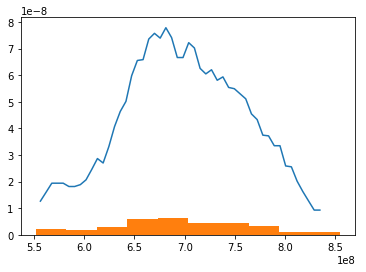

In [100]:
plt.plot(a_xDomain, a_xPr)
plt.hist(a_bPop, normed=True)
plt.show()

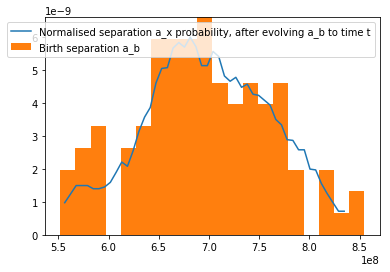

In [111]:
# Hacked normalisation
normedPr = [6e-9*float(i)/max(a_xPr) for i in a_xPr]
plt.plot(a_xDomain, normedPr)
plt.hist(a_bPop, normed=True, bins=20) # NORMED WORKING?
plt.legend(["separation a_x probability, after evolving a_b to time t", "Birth separation a_b"])
plt.show()

In [ ]:
# for a_x in np.linspace(0, 100*solarRadius, 20):
    
#     tIntegralTotal = 0
#     for t in np.linspace(t_i, t_f, 10): # For 10 times between t_i and t_f
#         # pi_thetaX_given_thetaB_t(ax, ab, t):
#         forwardedPop = scipy.stats.gaussian_kde(orbR(sunMass, sunMass, a_b, t, G=6.674e-8, c=3e8, delta=True))
#         pi_thetaX_given_thetaB_tRes = forwardedPop.evaluate(a_x)
        
#         integralPart = pi_t(t) * pi_thetaX_given_thetaB_tRes * pi_ab(a_b)
        
# > f = lambda y, x: x*y**2
# >>> integrate.dblquad(f, 0, 2, lambda x: 0, lambda x: 1)

We want $\pi(a_x|a_b,t)$ to act like a delta function, returning the ~~probability of the separation a_x at time t given the birth parameters.~~ OR returning 0 or 1 depending if a_x=a_b after time forwarding or not? ~~**Either way I think this needs to be discretized to do some forwarding in time? or at least to do root finding of the orbitDecay function to then know where to place a delta function.**~~

~~I discretize the integral in time t, so that for each step we are able to 'play forward' the current distribution of birth parameters $a_b\in\theta_b$, then create a kernal estimation of the new distribution to create an interpolated probability distribution.~~
